# Logistic Regression on Amazon Food Reviews

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# General Packages
import os
import sqlite3
import pandas as pd
import numpy as np
import string
import re
import nltk
import datetime
import time
from decimal import *
import math
import itertools
from tqdm import tqdm

# Plotting Packages
import matplotlib
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

# Packages for Tfidf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Packages for BOW (Bag of words)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import TimeSeriesSplit
from prettytable import PrettyTable
from prettytable import MSWORD_FRIENDLY
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score,average_precision_score,roc_auc_score
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

# Packages for Word 2 Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from nltk.corpus import stopwords

In [2]:
# Formaing Output using pretty table
Pretty = PrettyTable(["Model","Search Algorithm","Best Hyper Parameter","Elapsed Time"," Train Score ","Test Score"])
Pretty.set_style(MSWORD_FRIENDLY)
print(Pretty)

| Model | Search Algorithm | Best Hyper Parameter | Elapsed Time |  Train Score  | Test Score |


### Preprocessing Stage: Cleansed Stop Words, Punctuations & Html tags

In [3]:
#Connecting the Sqlite file after the Preprocessing Stage
os.chdir('/Users/sujis/Downloads/AI/New Amazon Reviews')
#os.chdir('C:\Users\sujit.venkata\Downloads\Dev & Imp works\Applied AI')
con = sqlite3.connect('final.sqlite') 
final= pd.read_sql_query(""" SELECT * FROM Reviews """, con) 

In [4]:
#final['Score'].value_counts()
final=final.head(150000)

In [5]:
#Sorting the Dataframe with Date to apply Timebased Split
final_dataset=final.sort_values(by='Time',ascending=1)

In [6]:
# create design matrix X and target vector y
X = np.array(final_dataset.iloc[:, 0:12]) # end index is exclusive
Y = np.array(final_dataset['Score']) # showing you two ways of indexing a pandas df

In [7]:
#Time based split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [8]:
#Splitting the Dataset into Train set & Test set
for train_index, test_index in tscv.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   Y_train, Y_test = Y[train_index], Y[test_index]

TRAIN: [    0     1     2 ... 24997 24998 24999] TEST: [25000 25001 25002 ... 49997 49998 49999]
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [50000 50001 50002 ... 74997 74998 74999]
TRAIN: [    0     1     2 ... 74997 74998 74999] TEST: [75000 75001 75002 ... 99997 99998 99999]
TRAIN: [    0     1     2 ... 99997 99998 99999] TEST: [100000 100001 100002 ... 124997 124998 124999]
TRAIN: [     0      1      2 ... 124997 124998 124999] TEST: [125000 125001 125002 ... 149997 149998 149999]


In [9]:
print(X_train.shape)
print(X_test.shape)
print('-------------------')
print(Y_train.shape)
print(Y_test.shape)

(125000, 12)
(25000, 12)
-------------------
(125000,)
(25000,)


In [10]:
# Converting X_Train, X_cv & X_test data is  to Dataframe for the ease of use
X_train_data=pd.DataFrame(X_train, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText']) 

X_test_data=pd.DataFrame(X_test, columns=['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText']) 


## Bag of Words

In [11]:
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(X_train_data['CleanedText'].values)
# Bag of Words : Train Data Set
Train_X_vector = vectorizer.transform(X_train_data['CleanedText'].values)
# summarize encoded vector
print(Train_X_vector.shape)

(125000, 41950)


In [12]:
#Test Data Set
Test_X_vector = vectorizer.transform(X_test_data['CleanedText'].values)
print(Test_X_vector.shape)

(25000, 41950)


In [13]:
print(Train_X_vector.shape)
print(Test_X_vector.shape)
print('-------------------')
print(Y_train.shape)
print(Y_test.shape)

(125000, 41950)
(25000, 41950)
-------------------
(125000,)
(25000,)


In [14]:
# Standardsing features using preprocessing algorithm
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler
X_maxabs = MaxAbsScaler().fit(Train_X_vector)
X_train_maxabs=X_maxabs.transform(Train_X_vector)
X_test_maxabs=X_maxabs.transform(Test_X_vector)

In [15]:
print(X_train_maxabs.shape)
print(X_test_maxabs.shape)
print('-------------------')
print(Y_train.shape)
print(Y_test.shape)

(125000, 41950)
(25000, 41950)
-------------------
(125000,)
(25000,)


## Random Search Cross Validation

In [16]:
# Defining a function & printing Alpha parameter Range
def Power(n): 
    res=[]
    for each in np.arange(-4,3,1):
        res.append(math.pow(n,each))
    return res
  
# Taking powers of numbers
pars = (1,2,10)
result = map(Power, pars)
pars = list(itertools.chain.from_iterable(list(result)))
pars=list(set(pars))
pars.sort()
pars

[0.0001,
 0.001,
 0.01,
 0.0625,
 0.1,
 0.125,
 0.25,
 0.5,
 1.0,
 2.0,
 4.0,
 10.0,
 100.0]

In [17]:
# Naive Bayes Model
model = LogisticRegression(penalty='l2',random_state=42,multi_class='multinomial',solver='lbfgs',
                           n_jobs=-1,class_weight='balanced')
#Hyper Parameters Set
params = {'C':pars}

scorer=make_scorer(f1_score,average='weighted')
   
my_cv = TimeSeriesSplit(n_splits=5).split(X_train_maxabs)

clf = RandomizedSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_distributions=params,verbose=10,n_jobs=-1)

In [18]:
%%time
start_time = time.time()
clf.fit(X_train_maxabs,Y_train)
elapsed_time = time.time() - start_time

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


CPU times: user 4.28 s, sys: 602 ms, total: 4.89 s
Wall time: 2min


In [19]:
Train_Score = clf.best_score_

In [20]:
pred=clf.predict(X_test_maxabs)
Test_Score = f1_score(Y_test, pred, average='micro')
print('The Test Score of the Naive Bayes Classifier for Alpha = %0.3f is %0.2f' % (clf.best_params_['C'], Test_Score))

The Test Score of the Naive Bayes Classifier for Alpha = 2.000 is 0.89


In [21]:
Pretty.add_row(["Bag of Words","Random Search CV",clf.best_params_['C'],elapsed_time,'{0:.2}'.format(Train_Score),'{0:.2}'.format(Test_Score)])

In [22]:
print(Pretty)

|    Model     | Search Algorithm | Best Hyper Parameter |   Elapsed Time   |  Train Score  | Test Score |
| Bag of Words | Random Search CV |         2.0          | 120.440593957901 |      0.9      |    0.89    |


## Grid Search Cross Validation

In [23]:
# Defining a function & printing Alpha parameter Range
def Power(n): 
    res=[]
    for each in np.arange(-4,3,1):
        res.append(math.pow(n,each))
    return res
  
# Taking powers of numbers
pars = (1,2,10)
result = map(Power, pars)
pars = list(itertools.chain.from_iterable(list(result)))
pars=list(set(pars))
pars.sort()
pars

[0.0001,
 0.001,
 0.01,
 0.0625,
 0.1,
 0.125,
 0.25,
 0.5,
 1.0,
 2.0,
 4.0,
 10.0,
 100.0]

In [24]:
# Naive Bayes Model
model = LogisticRegression(penalty='l2',random_state=42,multi_class='multinomial',solver='lbfgs',n_jobs=-1)
#Hyper Parameters Set
params = {'C':pars}

scorer=make_scorer(f1_score,average='micro')
   
my_cv = TimeSeriesSplit(n_splits=5).split(X_train_maxabs)

clf = GridSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_grid=params,verbose=20)

In [25]:
%%time
start_time=time.time()
clf.fit(X_train_maxabs,Y_train)
elapsed_time = time.time() - start_time

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... C=0.0001, score=0.8853741659866557, total=   0.6s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ................ C=0.0001, score=0.866269860317765, total=   0.8s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] ............... C=0.0001, score=0.8372293956703307, total=   1.1s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s


[CV] ................ C=0.0001, score=0.827965247443959, total=   1.4s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.8s remaining:    0.0s


[CV] ............... C=0.0001, score=0.8248931982911727, total=   1.8s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.5s remaining:    0.0s


[CV] ................ C=0.001, score=0.8853741659866557, total=   0.6s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.3s remaining:    0.0s


[CV] ................. C=0.001, score=0.866269860317765, total=   0.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   10.6s remaining:    0.0s


[CV] ................ C=0.001, score=0.8372293956703307, total=   1.3s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.4s remaining:    0.0s


[CV] ................. C=0.001, score=0.827965247443959, total=   1.7s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   14.9s remaining:    0.0s


[CV] ................. C=0.001, score=0.824941199059185, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s remaining:    0.0s


[CV] ................. C=0.01, score=0.8854221667546682, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   18.9s remaining:    0.0s


[CV] ................. C=0.01, score=0.8672298756780108, total=   1.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   20.4s remaining:    0.0s


[CV] ................. C=0.01, score=0.8404454471271541, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   22.7s remaining:    0.0s


[CV] ................. C=0.01, score=0.8376134018144291, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   25.9s remaining:    0.0s


[CV] ................. C=0.01, score=0.8413574617193875, total=   3.3s
[CV] C=0.0625 ........................................................


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   30.2s remaining:    0.0s


[CV] ............... C=0.0625, score=0.8906062496999952, total=   1.0s
[CV] C=0.0625 ........................................................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   31.4s remaining:    0.0s


[CV] ............... C=0.0625, score=0.8869581913310612, total=   1.5s
[CV] C=0.0625 ........................................................


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   33.2s remaining:    0.0s


[CV] ............... C=0.0625, score=0.8742379878078049, total=   2.3s
[CV] C=0.0625 ........................................................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   36.0s remaining:    0.0s


[CV] ............... C=0.0625, score=0.8784620553928862, total=   2.9s
[CV] C=0.0625 ........................................................


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   39.6s remaining:    0.0s


[CV] ............... C=0.0625, score=0.8868621897950366, total=   4.7s
[CV] C=0.1 ...........................................................
[CV] ................... C=0.1, score=0.896414342629482, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8942063073009168, total=   1.8s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8828301252820046, total=   2.8s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8878702059232948, total=   4.0s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8942543080689291, total=   5.2s
[CV] C=0.125 .........................................................
[CV] ................ C=0.125, score=0.8990063841021456, total=   1.1s
[CV] C=0.125 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  4.2min finished


CPU times: user 1min 5s, sys: 2.57 s, total: 1min 8s
Wall time: 4min 18s


In [26]:
# Fetching Test, Train, Rank & Alpha values from GridSearchCV
p=[]
for each in clf.cv_results_['params']:
    p.append(each['C'])
p_rank=list(clf.cv_results_['rank_test_score'])
p_test=list(clf.cv_results_['mean_test_score'])
p_train=list(clf.cv_results_['mean_train_score'])

# Converting into Dataframe and sorted it according to Parameter
df=pd.DataFrame({'Parameter':p,'Rank':p_rank,'Mean Train Score':p_test,'Mean Test Score':p_test})
df=df.sort_values(by='Parameter',ascending=1)
df['Mean Test Score']=1-df['Mean Test Score']

# Lowest Misclassification Error (x,y) co-ordinates
xy=min(zip(df['Mean Test Score'],df['Parameter']))

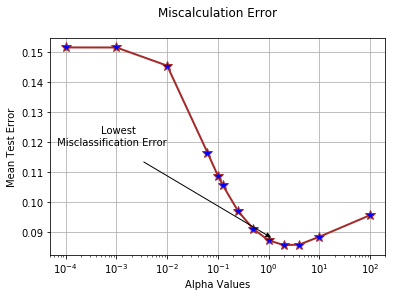

<Figure size 432x288 with 0 Axes>

In [27]:
#plotting Misclassification Error
error=plt.semilogx('Parameter', 'Mean Test Score', data=df, marker='*',
             color='brown',linewidth=2,ls='-',markerfacecolor='blue',markersize=10.0)
plt.ylabel('Mean Test Error')
plt.xlabel('Alpha Values')
plt.title('Miscalculation Error\n')
plt.gca().set_facecolor('xkcd:white')
plt.gca().annotate('Lowest          \n Misclassification Error\n', xy=(xy[1],xy[0]), xytext=(0.01, 0.120),
                   ha="right", va="center",
                   arrowprops=dict(arrowstyle="-|>",fc="k", ec="k",shrinkB=15,connectionstyle="arc3,rad=0")
                  )
plt.grid() 
fig = plt.figure()

In [28]:
clf.best_score_

0.9142706283300532

### Multicollinarity Check with Pertubation Technique

In [29]:
model = LogisticRegression(penalty='l2',C=clf.best_params_['C'],random_state=42,multi_class='multinomial', solver='lbfgs',n_jobs=-1)
model.fit(X_train_maxabs, Y_train)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
w=model.coef_
print(w)

[[0.22873771 0.0025856  0.02936398 ... 0.49141622 0.01540429 0.04419488]]


In [31]:
X_train_maxabs_2=X_train_maxabs
X_train_maxabs_2.data=X_train_maxabs_2.data+0.01

In [32]:
# W2
model_2 = LogisticRegression(penalty='l2',C=clf.best_params_['C'],multi_class='multinomial',random_state=42, solver='lbfgs',n_jobs=-1)
model_2.fit(X_train_maxabs_2, Y_train)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
w2=model_2.coef_

In [34]:
abs_w=(abs(w-w2)/abs(w))*100

In [35]:
w_percent=[]
for each in abs_w[0]:
    w_percent.append(float('{0:.3s}'.format(str(each))))

In [36]:
Weights=[]
weights_f=[]
feats=[]
   
for each in np.arange(0,80,5):
    features = list(filter(lambda x: float(x) < each, w_percent))
    weights_f.append(each)
    feats.append(len(features))
    
print(weights_f)
print(feats)
df=pd.DataFrame({'Weight':weights_f,'Features':feats},index=None)
w_f=zip(weights_f,feats)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
[0, 22112, 31296, 35414, 37663, 38878, 39557, 40000, 40352, 40604, 40770, 40912, 41048, 41144, 41237, 41322]


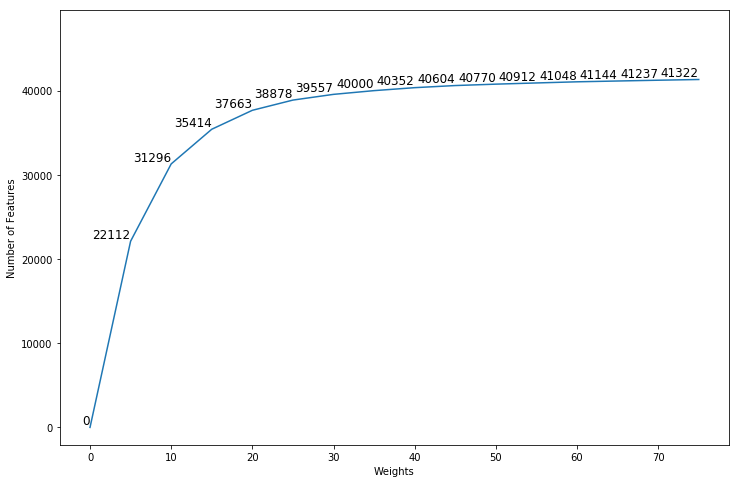

In [37]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
plt.plot(sorted(weights_f),sorted(feats))

for xy in zip(weights_f,feats):
    plt.annotate('%s' % xy[1], xy=xy, textcoords='data',ha="right", va="bottom",fontsize='12')

plt.xlabel('Weights')
plt.ylabel('Number of Features')
plt.gca().set_ylim(top=(max(feats)+0.2*max(feats)))
plt.show()


### Observation
 From the above plot, we can observe that the threshold value will be 20

In [38]:
print ('The Features whose percentage change are less than the Threshold Value : %d'%len(list(filter(lambda x: float(x) < 25, w_percent))))
print ('\nThe Features whose percentage change are more than the Threshold Value : %d'%len(list(filter(lambda x: float(x) > 25, w_percent))))

The Features whose percentage change are less than the Threshold Value : 38878

The Features whose percentage change are more than the Threshold Value : 2918


In [39]:
Threshold_Features = list(filter(lambda x: float(x) > 25, w_percent))

In [40]:
weight_threshold=np.take(w,Threshold_Features)
threshold_f=np.take(vectorizer.get_feature_names(),weight_threshold.argsort())

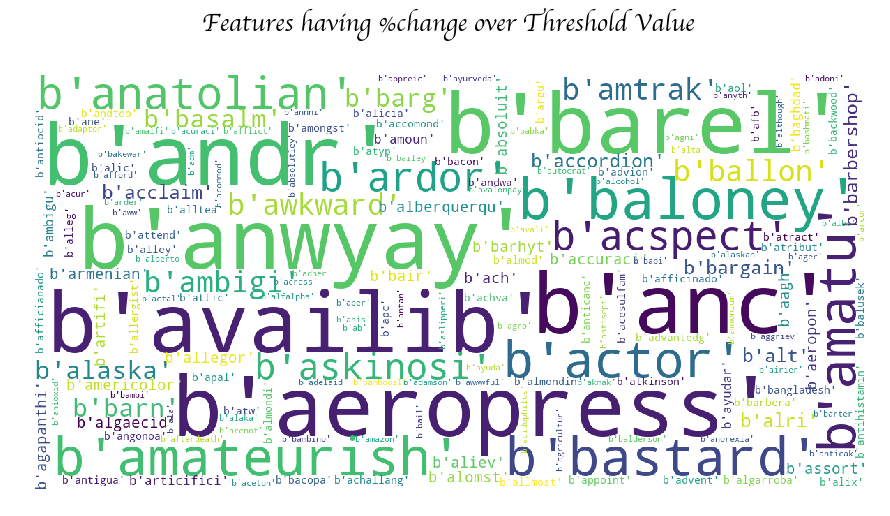

In [41]:
Crossed_threshold=[]
for each in threshold_f:
    Crossed_threshold.append(each.encode('utf-8'))

wordcloud = WordCloud(    background_color ='white',
                          stopwords=stopwords.words(),
                          max_words=200,
                          max_font_size=40, 
                          scale=3,
                          random_state=42
                         ).generate(str(Crossed_threshold))

fig = plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Features having %change over Threshold Value \n'
          , fontsize=25,fontname='cursive',color='black')
plt.show()

### Sparsity

In [42]:
%%time
Non_Zero_Percent=[]
C=[]
for each in (10000,1000,100,10,1,0.1,0.01,0.009,0.001,0.0001):
    model = LogisticRegression(penalty='l1',C=each,random_state=42, solver='liblinear')
    model.fit(X_train_maxabs, Y_train)
    pred=model.coef_
    C.append(each)
    Non_Zero_Percent.append((Decimal((np.count_nonzero(pred))/Decimal(pred.shape[1])))*100)
    print(each , pred.shape[1] ,np.count_nonzero(pred) )

10000 41950 25492
1000 41950 22985
100 41950 19389
10 41950 13373
1 41950 3349
0.1 41950 405
0.01 41950 36
0.009 41950 29
0.001 41950 0
0.0001 41950 0
CPU times: user 29.3 s, sys: 344 ms, total: 29.6 s
Wall time: 29.6 s


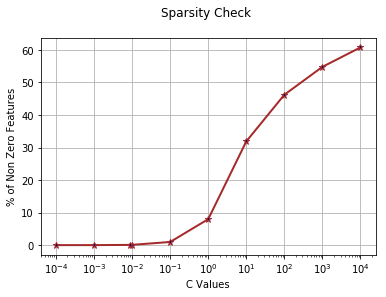

<Figure size 432x288 with 0 Axes>

In [43]:
#plotting Misclassification Error
error=plt.semilogx(C,Non_Zero_Percent, marker='*',color='brown',linewidth=2,ls='-',markerfacecolor='darkblue',markersize=7.0)
plt.ylabel('% of Non Zero Features')
plt.xlabel('C Values')
plt.title('Sparsity Check \n')
plt.gca().set_facecolor('xkcd:white')
plt.grid() 
fig = plt.figure()

In [44]:
model = LogisticRegression(penalty='l2',C=clf.best_params_['C'],multi_class='multinomial',random_state=42,solver='lbfgs',n_jobs=-1)
model.fit(X_train_maxabs, Y_train)
pred=model.predict(X_test_maxabs)
Test_Score = f1_score(Y_test, pred, average='micro')
print('The Test Score of the Naive Bayes Classifier for Alpha = %0.3f is %0.2f' % (clf.best_params_['C'], Test_Score))

The Test Score of the Naive Bayes Classifier for Alpha = 2.000 is 0.91


In [45]:
# Function for defining Feature Importnace and plotting them using Wordcloud
import random

def Feature_Importance(n,Vectorizer,colormap1,colormap2):
    coefs_with_fnames=sorted(zip(model.coef_[0],Vectorizer.get_feature_names()))
    Negative_Features=coefs_with_fnames[:n]
    Positive_Features=coefs_with_fnames[:-(n+1):-1]
    Pos_Features=[]
    for each in Positive_Features:
        Pos_Features.append(each[1].encode('utf-8'))
    Neg_Features=[]
    for each in Negative_Features:
        Neg_Features.append(each[1].encode('utf-8'))
    # Plotting for the Negaive Class
    
    
    wordcloud = WordCloud(    background_color ='white',
                          stopwords=stopwords.words(),
                          max_words=200,
                          max_font_size=40, 
                          scale=3,
                          random_state=42,
                          colormap=colormap1
                         ).generate(str(Neg_Features))

    fig = plt.figure(1,figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Feature Importance for Negative Class\n'
              , fontsize=25,fontname='cursive',color='black')
    plt.show()
    
    # Plotting for the Positive Class

    wordcloud = WordCloud(    background_color ='white',
                          stopwords=stopwords.words(),
                          max_words=200,
                          max_font_size=40, 
                          scale=3,
                          random_state=42,
                          colormap=colormap2
                         ).generate(str(Pos_Features))
    fig = plt.figure(1,figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Feature Importance for Positive Class\n'
              , fontsize=25,fontname='cursive',color='black')
    plt.show()
    
    return Negative_Features, Positive_Features

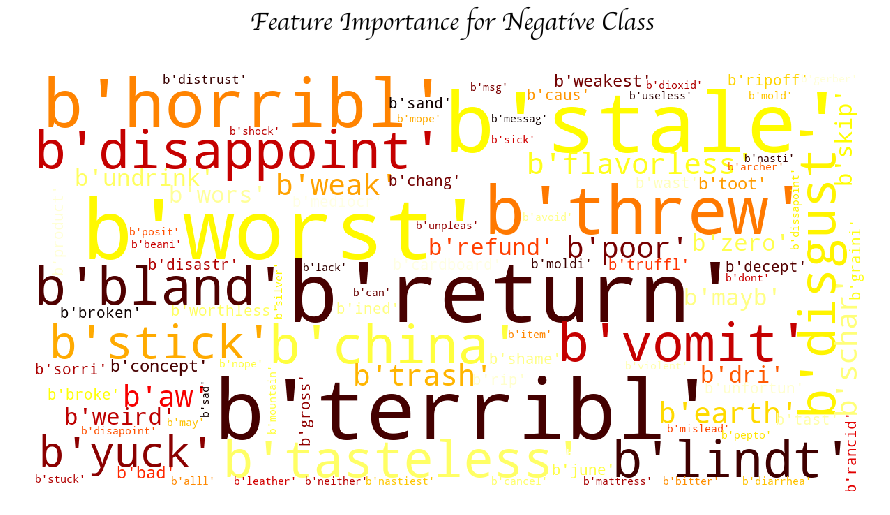

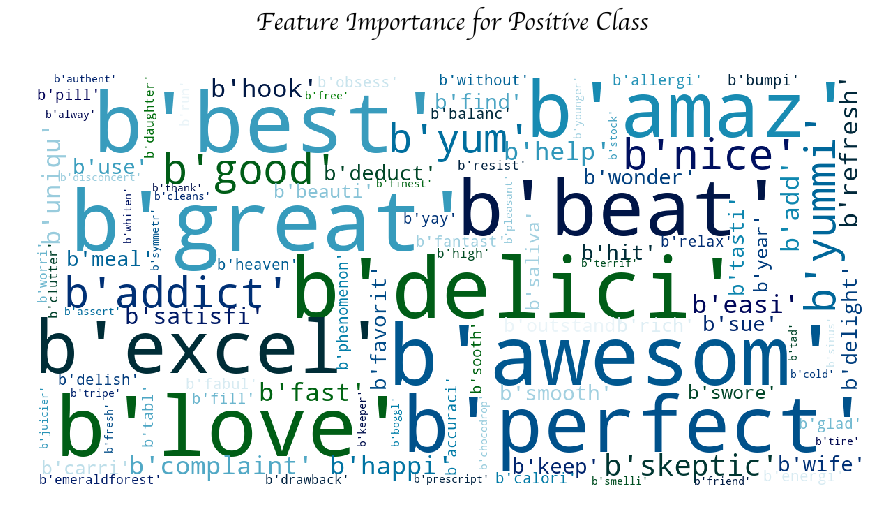

In [46]:
Neg_f,Pos_f=Feature_Importance(100,vectorizer,"hot","ocean")

In [47]:
print('The Best Mean Score obtained from the Grid Search is :%0.2f'%clf.best_score_)
print('The Best Parameter obtained from the Grid Search is : %f'%clf.best_params_['C'])

The Best Mean Score obtained from the Grid Search is :0.91
The Best Parameter obtained from the Grid Search is : 2.000000


In [48]:
Train_Score=clf.best_score_
print('The Train Score of Bernoulli Naive Bayes Algorithm is : %0.2f'%Train_Score)

The Train Score of Bernoulli Naive Bayes Algorithm is : 0.91


In [49]:
Conf_matrix=confusion_matrix(Y_test, pred)

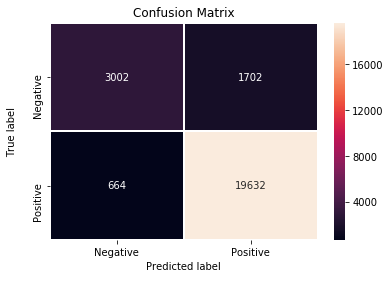

In [50]:
from matplotlib import *
import matplotlib.pyplot as plt

#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sns.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

In [51]:
Conf_matrix

array([[ 3002,  1702],
       [  664, 19632]])

In [52]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [53]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format(TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format(TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format(FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format(FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format(TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format(TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format((TP+TN)/(TP+FP+FN+TN))

In [54]:
Pretty.add_row(["Bag of Words","Grid Search CV",clf.best_params_['C'],elapsed_time,'{0:.2}'.format(Train_Score),'{0:.2}'.format(Test_Score)])

In [55]:
print(Pretty)

|    Model     | Search Algorithm | Best Hyper Parameter |   Elapsed Time   |  Train Score  | Test Score |
| Bag of Words | Random Search CV |         2.0          | 120.440593957901 |      0.9      |    0.89    |
| Bag of Words |  Grid Search CV  |         2.0          | 258.583438873291 |      0.91     |    0.91    |


In [56]:
print(classification_report(Y_test, pred))  

              precision    recall  f1-score   support

    negative       0.82      0.64      0.72      4704
    positive       0.92      0.97      0.94     20296

   micro avg       0.91      0.91      0.91     25000
   macro avg       0.87      0.80      0.83     25000
weighted avg       0.90      0.91      0.90     25000



## TF - IDF

In [57]:
tf_transformer = TfidfVectorizer(ngram_range=(1,2))
TF_vector=tf_transformer.fit(X_train_data['CleanedText'].values)
TF_train_Vector = TF_vector.transform(X_train_data['CleanedText'].values)
TF_train_Vector.shape

(125000, 1421473)

In [58]:
TF_test_Vector = TF_vector.transform(X_test_data['CleanedText'].values)
TF_test_Vector.shape

(25000, 1421473)

In [59]:
print(TF_train_Vector.shape)
print(TF_test_Vector.shape)
print('-------------------')
print(Y_train.shape)
print(Y_test.shape)

(125000, 1421473)
(25000, 1421473)
-------------------
(125000,)
(25000,)


In [60]:
# Standardsing features using preprocessing algorithm
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler
X_maxabs = MaxAbsScaler().fit(TF_train_Vector)
X_Tf_Train=X_maxabs.transform(TF_train_Vector)
X_Tf_Test=X_maxabs.transform(TF_test_Vector)

In [61]:
print(X_Tf_Train.shape)
print(X_Tf_Test.shape)
print('-------------------')
print(Y_train.shape)
print(Y_test.shape)

(125000, 1421473)
(25000, 1421473)
-------------------
(125000,)
(25000,)


## Random Search Cross Validation

In [62]:
# Defining a function & printing Alpha parameter Range
def Power(n): 
    res=[]
    for each in np.arange(-4,3,1):
        res.append(math.pow(n,each))
    return res
  
# Taking powers of numbers
pars = (1,2,10)
result = map(Power, pars)
pars = list(itertools.chain.from_iterable(list(result)))
pars=list(set(pars))
pars.sort()
pars

[0.0001,
 0.001,
 0.01,
 0.0625,
 0.1,
 0.125,
 0.25,
 0.5,
 1.0,
 2.0,
 4.0,
 10.0,
 100.0]

In [63]:
# Naive Bayes Model
model = LogisticRegression(penalty='l2',random_state=42,multi_class='multinomial',solver='lbfgs',
                           n_jobs=-1,class_weight='balanced')
#Hyper Parameters Set
params = {'C':pars}

scorer=make_scorer(f1_score,average='weighted')
   
my_cv = TimeSeriesSplit(n_splits=5).split(X_Tf_Train)

clf = RandomizedSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_distributions=params,verbose=10,n_jobs=-1)

In [64]:
%%time
start_time = time.time()
clf.fit(X_Tf_Train,Y_train)
elapsed_time = time.time() - start_time

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.1min finished


CPU times: user 4.87 s, sys: 1.05 s, total: 5.92 s
Wall time: 18min 19s


In [65]:
Train_Score = clf.best_score_

In [66]:
pred=clf.predict(X_Tf_Test)
Test_Score = f1_score(Y_test, pred, average='micro')
print('The Test Score of the Naive Bayes Classifier for Alpha = %0.3f is %0.2f' % (clf.best_params_['C'], Test_Score))

The Test Score of the Naive Bayes Classifier for Alpha = 0.500 is 0.92


In [67]:
Pretty.add_row(["TF - IDF","Random Search CV",clf.best_params_['C'],elapsed_time,'{0:.2}'.format(Train_Score),'{0:.2}'.format(Test_Score)])

In [68]:
print(Pretty)

|    Model     | Search Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
| Bag of Words | Random Search CV |         2.0          |  120.440593957901  |      0.9      |    0.89    |
| Bag of Words |  Grid Search CV  |         2.0          |  258.583438873291  |      0.91     |    0.91    |
|   TF - IDF   | Random Search CV |         0.5          | 1099.4646592140198 |      0.92     |    0.92    |


## Grid Search Cross Validation

In [69]:
# Defining a function & printing Alpha parameter Range
def Power(n): 
    res=[]
    for each in np.arange(-4,3,1):
        res.append(math.pow(n,each))
    return res
  
# Taking powers of numbers
pars = (1,2,10)
result = map(Power, pars)
pars = list(itertools.chain.from_iterable(list(result)))
pars=list(set(pars))
pars.sort()
pars

[0.0001,
 0.001,
 0.01,
 0.0625,
 0.1,
 0.125,
 0.25,
 0.5,
 1.0,
 2.0,
 4.0,
 10.0,
 100.0]

In [70]:
# Logistic Regression Model
model = LogisticRegression(penalty='l2',random_state=42,multi_class='multinomial',solver='lbfgs',n_jobs=-1)

#Hyper Parameters Set
params = {'C':pars}

scorer=make_scorer(f1_score,average='micro')
   
my_cv = TimeSeriesSplit(n_splits=5).split(X_Tf_Train)

clf = GridSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_grid=params,verbose=10)

In [71]:
%%time
start_time = time.time()
clf.fit(X_Tf_Train,Y_train)
elapsed_time = time.time() - start_time

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... C=0.0001, score=0.8853741659866557, total=   4.5s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] ................ C=0.0001, score=0.866269860317765, total=   5.3s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


[CV] ............... C=0.0001, score=0.8372293956703307, total=   5.8s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.7s remaining:    0.0s


[CV] ................ C=0.0001, score=0.827965247443959, total=   7.1s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.5s remaining:    0.0s


[CV] ............... C=0.0001, score=0.8248931982911727, total=   9.3s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.8s remaining:    0.0s


[CV] ................ C=0.001, score=0.8853741659866557, total=   6.0s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   41.0s remaining:    0.0s


[CV] ................. C=0.001, score=0.866269860317765, total=   7.5s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   48.8s remaining:    0.0s


[CV] ................ C=0.001, score=0.8372293956703307, total=   8.3s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   57.7s remaining:    0.0s


[CV] ................. C=0.001, score=0.827965247443959, total=  10.1s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] ................ C=0.001, score=0.8248931982911727, total=  12.7s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8853741659866557, total=   8.3s
[CV] C=0.01 ..........................................................
[CV] .................. C=0.01, score=0.867085873373974, total=   9.0s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8448615177842844, total=  16.0s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8517256276100418, total=  14.7s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8625738011808189, total=  20.1s
[CV] C=0.0625 ........................................................
[CV] ............... C=0.0625, score=0.8934382950127202, total=  12.7s
[CV] C=0.0625 ........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed: 42.8min finished


CPU times: user 1min 22s, sys: 8.73 s, total: 1min 30s
Wall time: 44min 11s


In [72]:
# Fetching Test, Train, Rank & Alpha values from GridSearchCV
p=[]
for each in clf.cv_results_['params']:
    p.append(each['C'])
p_rank=list(clf.cv_results_['rank_test_score'])
p_test=list(clf.cv_results_['mean_test_score'])
p_train=list(clf.cv_results_['mean_train_score'])

# Converting into Dataframe and sorted it according to Parameter
df=pd.DataFrame({'Parameter':p,'Rank':p_rank,'Mean Train Score':p_test,'Mean Test Score':p_test})
df=df.sort_values(by='Parameter',ascending=1)
df['Mean Test Score']=1-df['Mean Test Score']

# Lowest Misclassification Error (x,y) co-ordinates
xy=min(zip(df['Mean Test Score'],df['Parameter']))

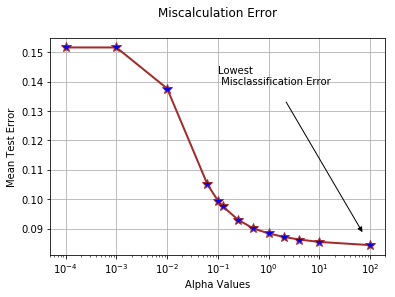

<Figure size 432x288 with 0 Axes>

In [73]:
#plotting Misclassification Error
error=plt.semilogx('Parameter', 'Mean Test Score', data=df, marker='*',
             color='brown',linewidth=2,ls='-',markerfacecolor='blue',markersize=10.0)
plt.ylabel('Mean Test Error')
plt.xlabel('Alpha Values')
plt.title('Miscalculation Error\n')
plt.gca().set_facecolor('xkcd:white')
plt.gca().annotate('Lowest          \n Misclassification Error\n', xy=(xy[1],xy[0]), xytext=(0.1, 0.140),
                   ha="left", va="center",
                   arrowprops=dict(arrowstyle="-|>",fc="k", ec="k",shrinkB=15,connectionstyle="arc3,rad=0")
                  )
plt.grid() 
fig = plt.figure()

In [74]:
clf.best_score_

0.9156434502952048

### Multicollinarity Check with Pertubation Technique

In [75]:
model = LogisticRegression(penalty='l2',C=clf.best_params_['C'],random_state=42,multi_class='multinomial', solver='lbfgs',n_jobs=-1)
model.fit(X_Tf_Train, Y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [76]:
w=model.coef_
print(w)

[[-0.02063695  0.00543528 -0.10558921 ...  0.00756934  0.00639806
   0.00639806]]


In [77]:
X_Tf_Train_2=X_Tf_Train
X_Tf_Train_2.data=X_Tf_Train_2.data+0.01

In [78]:
# W2
model_2 = LogisticRegression(penalty='l2',C=clf.best_params_['C'],multi_class='multinomial',random_state=42, solver='lbfgs')
model_2.fit(X_Tf_Train_2, Y_train)

/Users/sujis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [79]:
w2=model_2.coef_

In [80]:
abs_w=(abs(w-w2)/abs(w))*100

In [81]:
w_percent=[]
for each in abs_w[0]:
    w_percent.append(float('{0:.3s}'.format(str(each))))

In [82]:
Weights=[]
weights_f=[]
feats=[]
   
for each in np.arange(0,80,5):
    features = list(filter(lambda x: float(x) < each, w_percent))
    weights_f.append(each)
    feats.append(len(features))
    
print(weights_f)
print(feats)
df=pd.DataFrame({'Weight':weights_f,'Features':feats},index=None)
w_f=zip(weights_f,feats)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
[0, 692347, 897715, 1094711, 1297973, 1366503, 1393318, 1402600, 1406544, 1407591, 1408733, 1409770, 1410740, 1411326, 1411831, 1412215]


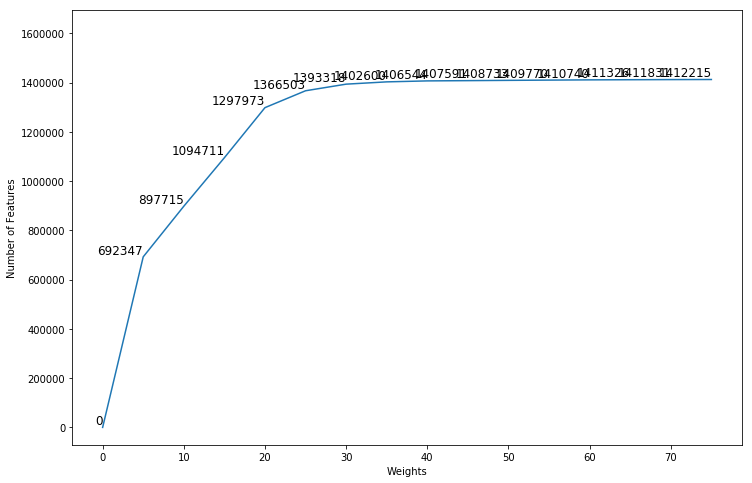

In [83]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
plt.plot(sorted(weights_f),sorted(feats))

for xy in zip(weights_f,feats):
    plt.annotate('%s' % xy[1], xy=xy, textcoords='data',ha="right", va="bottom",fontsize='12')

plt.xlabel('Weights')
plt.ylabel('Number of Features')
plt.gca().set_ylim(top=(max(feats)+0.2*max(feats)))
plt.show()


### Observation
 From the above plot, we can observe that the threshold value will be 25

In [84]:
print ('The Features whose percentage change are less than the Threshold Value : %d'%len(list(filter(lambda x: float(x) < 25, w_percent))))
print ('\nThe Features whose percentage change are more than the Threshold Value : %d'%len(list(filter(lambda x: float(x) > 25, w_percent))))

The Features whose percentage change are less than the Threshold Value : 1366503

The Features whose percentage change are more than the Threshold Value : 47098


In [85]:
Threshold_Features = list(filter(lambda x: float(x) > 30, w_percent))

In [86]:
weight_threshold=np.take(w,Threshold_Features)
threshold_f=np.take(TF_vector.get_feature_names(),weight_threshold.argsort())

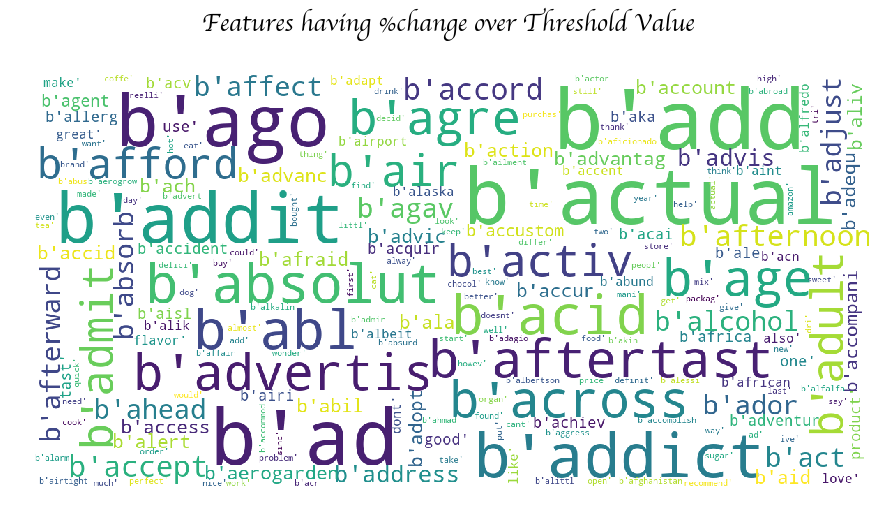

In [87]:
Crossed_threshold=[]
for each in threshold_f:
    Crossed_threshold.append(each.encode('utf-8'))

wordcloud = WordCloud(    background_color ='white',
                          stopwords=stopwords.words(),
                          max_words=200,
                          max_font_size=40, 
                          scale=3,
                          random_state=42
                         ).generate(str(Crossed_threshold))

fig = plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Features having %change over Threshold Value \n'
          , fontsize=25,fontname='cursive',color='black')
plt.show()

### Sparsity

In [88]:
%%time
Non_Zero_Percent=[]
C=[]
for each in (10000,1000,100,10,1,0.1,0.01,0.009,0.001,0.0001):
    model = LogisticRegression(penalty='l1',C=each,random_state=42, solver='liblinear')
    model.fit(X_Tf_Train, Y_train)
    pred=model.coef_
    C.append(each)
    Non_Zero_Percent.append((Decimal((np.count_nonzero(pred))/Decimal(pred.shape[1])))*100)
    print(each , pred.shape[1] ,np.count_nonzero(pred) )

10000 1421473 205248
1000 1421473 79578
100 1421473 41545
10 1421473 29993
1 1421473 8543
0.1 1421473 557
0.01 1421473 57
0.009 1421473 46
0.001 1421473 0
0.0001 1421473 0
CPU times: user 1min 26s, sys: 2.6 s, total: 1min 29s
Wall time: 1min 30s


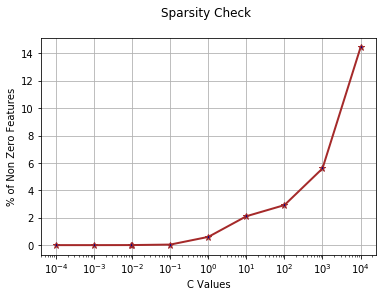

<Figure size 432x288 with 0 Axes>

In [89]:
#plotting Misclassification Error
error=plt.semilogx(C,Non_Zero_Percent, marker='*',color='brown',linewidth=2,ls='-',markerfacecolor='darkblue',markersize=7.0)
plt.ylabel('% of Non Zero Features')
plt.xlabel('C Values')
plt.title('Sparsity Check \n')
plt.gca().set_facecolor('xkcd:white')
plt.grid() 
fig = plt.figure()

In [90]:
model = LogisticRegression(penalty='l2',C=clf.best_params_['C'],multi_class='multinomial',random_state=42, solver='lbfgs',n_jobs=-1)
model.fit(X_Tf_Train, Y_train)
pred=model.predict(X_Tf_Test)
Test_Score = f1_score(Y_test, pred, average='micro')
print('The Test Score of the Naive Bayes Classifier for Alpha = %0.3f is %0.2f' % (clf.best_params_['C'], Test_Score))

The Test Score of the Naive Bayes Classifier for Alpha = 100.000 is 0.92


In [91]:
# Function for defining Feature Importnace and plotting them using Wordcloud
import random

def Feature_Importance(n,Vectorizer,colormap1,colormap2):
    coefs_with_fnames=sorted(zip(model.coef_[0],Vectorizer.get_feature_names()))
    Negative_Features=coefs_with_fnames[:n]
    Positive_Features=coefs_with_fnames[:-(n+1):-1]
    Pos_Features=[]
    for each in Positive_Features:
        Pos_Features.append(each[1].encode('utf-8'))
    Neg_Features=[]
    for each in Negative_Features:
        Neg_Features.append(each[1].encode('utf-8'))
    # Plotting for the Negaive Class
    
    
    wordcloud = WordCloud(    background_color ='white',
                          stopwords=stopwords.words(),
                          max_words=200,
                          max_font_size=40, 
                          scale=3,
                          random_state=42,
                          colormap=colormap1
                         ).generate(str(Neg_Features))

    fig = plt.figure(1,figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Feature Importance for Negative Class\n'
              , fontsize=25,fontname='cursive',color='black')
    plt.show()
    
    # Plotting for the Positive Class

    wordcloud = WordCloud(    background_color ='white',
                          stopwords=stopwords.words(),
                          max_words=200,
                          max_font_size=40, 
                          scale=3,
                          random_state=42,
                          colormap=colormap2
                         ).generate(str(Pos_Features))
    fig = plt.figure(1,figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Feature Importance for Positive Class\n'
              , fontsize=25,fontname='cursive',color='black')
    plt.show()
    
    return Negative_Features, Positive_Features

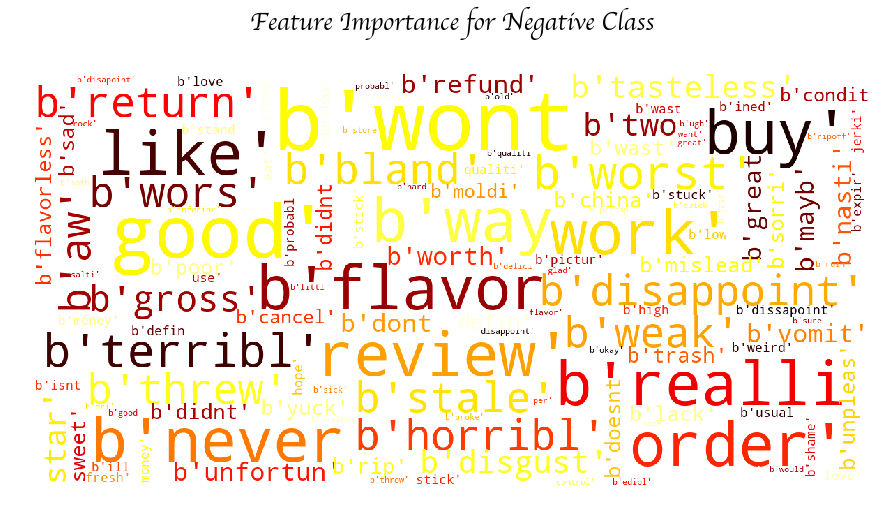

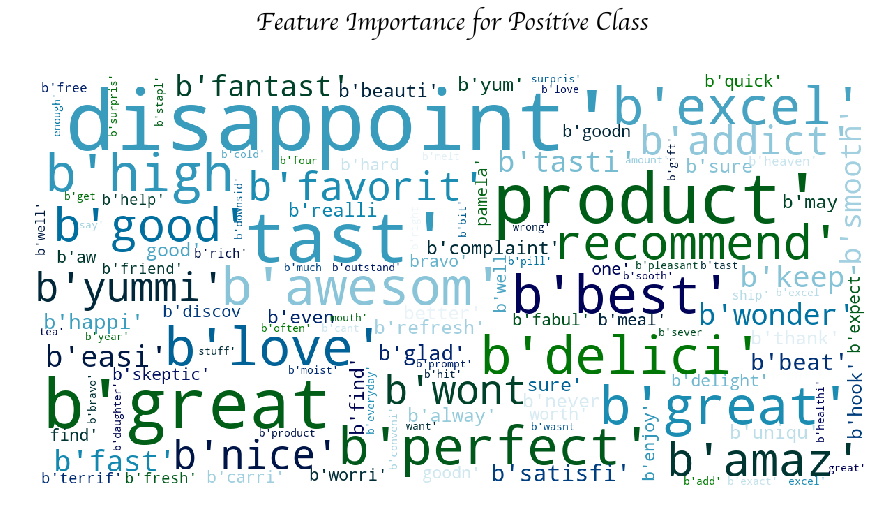

In [92]:
Neg_f,Pos_f=Feature_Importance(100,tf_transformer,"hot","ocean")

In [93]:
print('The Best Mean Score obtained from the Grid Search is :%0.2f'%clf.best_score_)
print('The Best Parameter obtained from the Grid Search is : %f'%clf.best_params_['C'])

The Best Mean Score obtained from the Grid Search is :0.92
The Best Parameter obtained from the Grid Search is : 100.000000


In [94]:
Train_Score=clf.best_score_
print('The Train Score of Bernoulli Naive Bayes Algorithm is : %0.2f'%Train_Score)

The Train Score of Bernoulli Naive Bayes Algorithm is : 0.92


In [95]:
Conf_matrix=confusion_matrix(Y_test, pred)

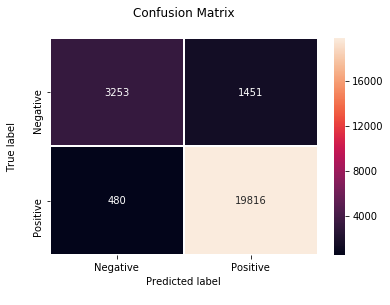

In [96]:
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sns.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,
                 annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.title("Confusion Matrix\n") # You can comment this line out if you don't need title
plt.show()

In [97]:
Conf_matrix

array([[ 3253,  1451],
       [  480, 19816]])

In [98]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [99]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format((TP)/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format((TN)/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format((FP)/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format((FN)/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format((TP)/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format((TN)/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format((TP+TN)/(TP+FP+FN+TN))

In [100]:
Pretty.add_row(["TF - IDF","Grid Search CV",clf.best_params_['C'],elapsed_time,'{0:.2}'.format(Train_Score),'{0:.2}'.format(Test_Score)])

In [101]:
print(classification_report(Y_test, pred))  

              precision    recall  f1-score   support

    negative       0.87      0.69      0.77      4704
    positive       0.93      0.98      0.95     20296

   micro avg       0.92      0.92      0.92     25000
   macro avg       0.90      0.83      0.86     25000
weighted avg       0.92      0.92      0.92     25000



In [102]:
print(Pretty)

|    Model     | Search Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
| Bag of Words | Random Search CV |         2.0          |  120.440593957901  |      0.9      |    0.89    |
| Bag of Words |  Grid Search CV  |         2.0          |  258.583438873291  |      0.91     |    0.91    |
|   TF - IDF   | Random Search CV |         0.5          | 1099.4646592140198 |      0.92     |    0.92    |
|   TF - IDF   |  Grid Search CV  |        100.0         | 2651.639996290207  |      0.92     |    0.92    |


# Average Word 2 Vec

In [103]:
# Train your own Word2Vec model using your own text corpus for Training Dataset
i=0
list_of_sent=[]
for sent in X_train_data['CleanedText'].values:
    list_of_sent.append(sent.split())

# min_count = 5 considers only words that occured atleast 5 times
Trained_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

w2v_words = list(Trained_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13816
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach']


In [104]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 125000/125000 [04:40<00:00, 446.38it/s]

125000
50


In [105]:
Train_X=sent_vectors

In [106]:
df = pd.DataFrame.from_records(Train_X)
df.to_csv('Train_Aw2v_125.csv',index=False)

In [107]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_test=[]
for sent in X_test_data['CleanedText'].values:
    list_of_sent_test.append(sent.split())

In [108]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = Trained_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 25000/25000 [01:01<00:00, 406.17it/s]

25000
50


In [109]:
Test_X=sent_vectors

In [110]:
df = pd.DataFrame.from_records(Test_X)
df.to_csv('Test_Aw2v_125.csv',index=False)

In [111]:
# Standardsing features using preprocessing algorithm
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler
X_maxabs = MaxAbsScaler().fit(Train_X)
X_Train = X_maxabs.transform(Train_X)
X_Test = X_maxabs.transform(Test_X)

In [112]:
print(X_Train.shape)
print(X_Test.shape)
print('-------------------')
print(Y_train.shape)
print(Y_test.shape)

(125000, 50)
(25000, 50)
-------------------
(125000,)
(25000,)


## Random Search Cross Validation

In [113]:
# Defining a function & printing Alpha parameter Range
def Power(n): 
    res=[]
    for each in np.arange(-4,3,1):
        res.append(math.pow(n,each))
    return res
  
# Taking powers of numbers
pars = (1,2,10)
result = map(Power, pars)
pars = list(itertools.chain.from_iterable(list(result)))
pars=list(set(pars))
pars.sort()
pars

[0.0001,
 0.001,
 0.01,
 0.0625,
 0.1,
 0.125,
 0.25,
 0.5,
 1.0,
 2.0,
 4.0,
 10.0,
 100.0]

In [114]:
# Naive Bayes Model
model = LogisticRegression(penalty='l2',random_state=42,multi_class='multinomial',solver='lbfgs',
                           n_jobs=-1,class_weight='balanced')
#Hyper Parameters Set
params = {'C':pars}

scorer=make_scorer(f1_score,average='weighted')
   
my_cv = TimeSeriesSplit(n_splits=5).split(X_Train)

clf = RandomizedSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_distributions=params,verbose=10,n_jobs=-1)

In [115]:
%%time
start_time = time.time()
clf.fit(X_Train,Y_train)
elapsed_time = time.time() - start_time

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


CPU times: user 4.2 s, sys: 495 ms, total: 4.69 s
Wall time: 1min 13s


In [116]:
Train_Score = clf.best_score_

In [117]:
pred=clf.predict(X_Test)
Test_Score = f1_score(Y_test, pred, average='micro')
print('The Test Score of the Naive Bayes Classifier for Alpha = %0.3f is %0.2f' % (clf.best_params_['C'], Test_Score))

The Test Score of the Naive Bayes Classifier for Alpha = 2.000 is 0.81


In [118]:
Pretty.add_row(["Average Weighted W2V","Random Search CV",clf.best_params_['C'],elapsed_time,'{0:.2}'.format(Train_Score),'{0:.2}'.format(Test_Score)])

In [119]:
print(Pretty)

|        Model         | Search Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
|     Bag of Words     | Random Search CV |         2.0          |  120.440593957901  |      0.9      |    0.89    |
|     Bag of Words     |  Grid Search CV  |         2.0          |  258.583438873291  |      0.91     |    0.91    |
|       TF - IDF       | Random Search CV |         0.5          | 1099.4646592140198 |      0.92     |    0.92    |
|       TF - IDF       |  Grid Search CV  |        100.0         | 2651.639996290207  |      0.92     |    0.92    |
| Average Weighted W2V | Random Search CV |         2.0          | 73.14316415786743  |      0.83     |    0.81    |


## Grid Search Cross Validation

In [120]:
# Defining a function & printing Alpha parameter Range
def Power(n): 
    res=[]
    for each in np.arange(-4,3,1):
        res.append(math.pow(n,each))
    return res
  
# Taking powers of numbers
pars = (1,2,10)
result = map(Power, pars)
pars = list(itertools.chain.from_iterable(list(result)))
pars=list(set(pars))
pars.sort()
pars

[0.0001,
 0.001,
 0.01,
 0.0625,
 0.1,
 0.125,
 0.25,
 0.5,
 1.0,
 2.0,
 4.0,
 10.0,
 100.0]

In [121]:
# Logistic Regression Model
model = LogisticRegression(penalty='l2',random_state=42,multi_class='multinomial',solver='lbfgs',n_jobs=-1)

#Hyper Parameters Set
params = {'C':pars}

scorer=make_scorer(f1_score,average='micro')
   
my_cv = TimeSeriesSplit(n_splits=5).split(X_Train)

clf = GridSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_grid=params,verbose=10,n_jobs=-1)

In [122]:
%%time
start_time = time.time()
clf.fit(X_Train,Y_train)
elapsed_time = time.time() - start_time

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  1.2min finished


CPU times: user 5.18 s, sys: 477 ms, total: 5.65 s
Wall time: 1min 15s


In [123]:
Train_Score = clf.best_score_

In [124]:
pred=clf.predict(X_Test)
Test_Score = f1_score(Y_test, pred, average='micro')
print('The Test Score of the Naive Bayes Classifier for Alpha = %0.3f is %0.2f' % (clf.best_params_['C'], Test_Score))

The Test Score of the Naive Bayes Classifier for Alpha = 100.000 is 0.88


In [125]:
Pretty.add_row(["Average Weighted W2V","Grid Search CV",clf.best_params_['C'],elapsed_time,'{0:.2}'.format(Train_Score),'{0:.2}'.format(Test_Score)])

In [126]:
print(Pretty)

|        Model         | Search Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
|     Bag of Words     | Random Search CV |         2.0          |  120.440593957901  |      0.9      |    0.89    |
|     Bag of Words     |  Grid Search CV  |         2.0          |  258.583438873291  |      0.91     |    0.91    |
|       TF - IDF       | Random Search CV |         0.5          | 1099.4646592140198 |      0.92     |    0.92    |
|       TF - IDF       |  Grid Search CV  |        100.0         | 2651.639996290207  |      0.92     |    0.92    |
| Average Weighted W2V | Random Search CV |         2.0          | 73.14316415786743  |      0.83     |    0.81    |
| Average Weighted W2V |  Grid Search CV  |        100.0         | 75.61756324768066  |      0.89     |    0.88    |


# TF - IDF Weighted Average Word 2 Vec

In [127]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train_data['CleanedText'].values)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)

In [128]:
%%time
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 125000/125000 [04:55<00:00, 422.58it/s]

CPU times: user 4min 49s, sys: 21.4 s, total: 5min 10s
Wall time: 4min 55s


In [129]:
Train_X=tfidf_sent_vectors

In [130]:
%%time
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 25000/25000 [01:00<00:00, 415.92it/s]

CPU times: user 59.2 s, sys: 5.21 s, total: 1min 4s
Wall time: 1min


In [131]:
Test_X=tfidf_sent_vectors

In [132]:
# Standardsing features using preprocessing algorithm
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler
X_maxabs = MaxAbsScaler().fit(Train_X)
X_Train = X_maxabs.transform(Train_X)
X_Test = X_maxabs.transform(Test_X)

In [133]:
print(X_Train.shape)
print(X_Test.shape)
print('-------------------')
print(Y_train.shape)
print(Y_test.shape)

(125000, 50)
(25000, 50)
-------------------
(125000,)
(25000,)


## Random Search Cross Validation

In [134]:
# Defining a function & printing Alpha parameter Range
def Power(n): 
    res=[]
    for each in np.arange(-4,3,1):
        res.append(math.pow(n,each))
    return res
  
# Taking powers of numbers
pars = (1,2,10)
result = map(Power, pars)
pars = list(itertools.chain.from_iterable(list(result)))
pars=list(set(pars))
pars.sort()
pars

[0.0001,
 0.001,
 0.01,
 0.0625,
 0.1,
 0.125,
 0.25,
 0.5,
 1.0,
 2.0,
 4.0,
 10.0,
 100.0]

In [135]:
# Naive Bayes Model
model = LogisticRegression(penalty='l2',random_state=42,multi_class='multinomial',solver='lbfgs',
                           n_jobs=-1,class_weight='balanced')
#Hyper Parameters Set
params = {'C':pars}

scorer=make_scorer(f1_score,average='weighted')
   
my_cv = TimeSeriesSplit(n_splits=5).split(X_Train)

clf = RandomizedSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_distributions=params,verbose=10,n_jobs=-1)

In [136]:
%%time
start_time = time.time()
clf.fit(X_Train,Y_train)
elapsed_time = time.time() - start_time

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   52.4s finished


CPU times: user 4.11 s, sys: 563 ms, total: 4.67 s
Wall time: 58.1 s


In [137]:
Train_Score = clf.best_score_

In [138]:
pred=clf.predict(X_Test)
Test_Score = f1_score(Y_test, pred, average='micro')
print('The Test Score of the Naive Bayes Classifier for Alpha = %0.3f is %0.2f' % (clf.best_params_['C'], Test_Score))

The Test Score of the Naive Bayes Classifier for Alpha = 0.500 is 0.78


In [139]:
Pretty.add_row(["TF-IDF Weighted W2V","Random Search CV",clf.best_params_['C'],elapsed_time,'{0:.2}'.format(Train_Score),'{0:.2}'.format(Test_Score)])

In [140]:
print(Pretty)

|        Model         | Search Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
|     Bag of Words     | Random Search CV |         2.0          |  120.440593957901  |      0.9      |    0.89    |
|     Bag of Words     |  Grid Search CV  |         2.0          |  258.583438873291  |      0.91     |    0.91    |
|       TF - IDF       | Random Search CV |         0.5          | 1099.4646592140198 |      0.92     |    0.92    |
|       TF - IDF       |  Grid Search CV  |        100.0         | 2651.639996290207  |      0.92     |    0.92    |
| Average Weighted W2V | Random Search CV |         2.0          | 73.14316415786743  |      0.83     |    0.81    |
| Average Weighted W2V |  Grid Search CV  |        100.0         | 75.61756324768066  |      0.89     |    0.88    |
| TF-IDF Weighted W2V  | Random Search CV |         0.5          | 58.14875507354736  |      0.81     |    0.78    |


## Grid Search Cross Validation

In [141]:
# Defining a function & printing Alpha parameter Range
def Power(n): 
    res=[]
    for each in np.arange(-4,3,1):
        res.append(math.pow(n,each))
    return res
  
# Taking powers of numbers
pars = (1,2,10)
result = map(Power, pars)
pars = list(itertools.chain.from_iterable(list(result)))
pars=list(set(pars))
pars.sort()
pars

[0.0001,
 0.001,
 0.01,
 0.0625,
 0.1,
 0.125,
 0.25,
 0.5,
 1.0,
 2.0,
 4.0,
 10.0,
 100.0]

In [142]:
# Logistic Regression Model
model = LogisticRegression(penalty='l2',random_state=42,multi_class='multinomial',solver='lbfgs',n_jobs=-1)

#Hyper Parameters Set
params = {'C':pars}

scorer=make_scorer(f1_score,average='micro')
   
my_cv = TimeSeriesSplit(n_splits=5).split(X_Train)

clf = GridSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_grid=params,verbose=10,n_jobs=-1)

In [143]:
%%time
start_time = time.time()
clf.fit(X_Train,Y_train)
elapsed_time = time.time() - start_time

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  1.1min finished


CPU times: user 5.16 s, sys: 577 ms, total: 5.74 s
Wall time: 1min 9s


In [144]:
Train_Score = clf.best_score_

In [145]:
pred=clf.predict(X_Test)
Test_Score = f1_score(Y_test, pred, average='micro')
print('The Test Score of the Naive Bayes Classifier for Alpha = %0.3f is %0.2f' % (clf.best_params_['C'], Test_Score))

The Test Score of the Naive Bayes Classifier for Alpha = 4.000 is 0.86


In [146]:
Pretty.add_row(["TF-IDF Weighted W2V","Grid Search CV",clf.best_params_['C'],elapsed_time,'{0:.2}'.format(Train_Score),'{0:.2}'.format(Test_Score)])

In [147]:
print(Pretty)

|        Model         | Search Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
|     Bag of Words     | Random Search CV |         2.0          |  120.440593957901  |      0.9      |    0.89    |
|     Bag of Words     |  Grid Search CV  |         2.0          |  258.583438873291  |      0.91     |    0.91    |
|       TF - IDF       | Random Search CV |         0.5          | 1099.4646592140198 |      0.92     |    0.92    |
|       TF - IDF       |  Grid Search CV  |        100.0         | 2651.639996290207  |      0.92     |    0.92    |
| Average Weighted W2V | Random Search CV |         2.0          | 73.14316415786743  |      0.83     |    0.81    |
| Average Weighted W2V |  Grid Search CV  |        100.0         | 75.61756324768066  |      0.89     |    0.88    |
| TF-IDF Weighted W2V  | Random Search CV |         0.5          | 58.14875507354736  |      0.81     |    0.78    |
| TF-IDF Weighted W2V  |  Grid Search CV  |         4.0         

## Conclusion
        I am concluding the assignment by performing all the four vectorizers and logistic regression. I also performed sparsity & Pertubation check for TF-IDF & BOW vectorizers.